In [63]:
import numpy as np
%pylab inline
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import proj3d
from matplotlib.patches import FancyArrowPatch
from sklearn.decomposition import PCA as sklearnPCA

Populating the interactive namespace from numpy and matplotlib


# Summarizing the PCA approach

Listed below are the 6 general steps for performing a principal component analysis, which we will investigate in the following sections.

1) Take the whole dataset consisting of d-dimensional samples ignoring the class labels

2) Compute the $d$-dimensional mean vector (i.e., the means for every dimension of the whole dataset)

3) Compute the scatter matrix (alternatively, the covariance matrix) of the whole data set

4) Compute eigenvectors ($e_1,e_2,...,e_d$) and corresponding eigenvalues ($λ_1,λ_2,...,λ_d$)

5) Sort the eigenvectors by decreasing eigenvalues and choose $k$ eigenvectors with the largest eigenvalues to form a $d×k$ dimensional matrix W(where every column represents an eigenvector)

6) Use this $d×k$ eigenvector matrix to transform the samples onto the new subspace. This can be summarized by the mathematical equation: $y=W^T×x$(where x is a $d×1$-dimensional vector representing one sample, and $y$ is the transformed $k×1$-dimensional sample in the new subspace.)

## Generating a 3-D sample data:
Here we will concat two different "classes" of data as such. That first class has data which is all centered around `0` while the second class of data is centered around `1`. We make the problem simple by making covaraince matrices a diagnoal matrix, which means that the three classes will ensure that the three row vectors of each class's matrix will be independent of each other (covariance of 0) 

In [4]:
mu_vec1 = np.array([0,0,0]) # the mean of all the rows will be 0
cov_mat1 = np.array([[1,0,0],[0,1,0],[0,0,1]])
class1_sample = np.random.multivariate_normal(mu_vec1, cov_mat1, 20).T
class1_sample

array([[-0.52454022, -0.53530996, -0.86660231, -1.04570242, -0.92051193,
        -0.66828952, -0.12263065, -0.97913219,  0.23086207,  0.30358959,
         1.71419041,  0.52761773,  0.59901174,  0.25103419,  0.19351941,
         0.6249383 ,  0.41405468, -0.49508179,  0.35943078,  1.19433438],
       [-2.10997245,  0.49963143,  0.22137995,  0.05570088,  0.77268672,
        -1.07012989, -0.71282298, -2.10135577, -0.22105954, -0.65539643,
        -0.2787159 , -0.7341423 , -1.56765369,  2.75344388, -0.55020203,
         0.18363179, -0.61866369, -1.84965895,  0.43661751,  0.66088136],
       [-0.28242388, -0.34428406,  1.21258037, -1.10998456,  0.83597727,
        -0.00846975,  1.15590982, -1.27739052,  0.2206683 , -0.46843993,
         0.12285784,  0.36576992,  0.93639761,  0.64658198,  0.64330207,
        -0.37990565,  0.17437258,  1.45169422,  1.68891993,  0.06004239]])

In [10]:
mu_vec2 = np.array([1,1,1]) # the mean of all rows will be 1
cov_mat2 = np.array([[1,0,0],[0,1,0],[0,0,1]])
class2_sample = np.random.multivariate_normal(mu_vec2, cov_mat2, 20).T
class2_sample

array([[ 0.71875534,  1.99807856,  0.14903389,  0.83871267, -0.76794806,
         2.66890114,  0.24983061,  1.82444736,  3.52311335,  0.66576433,
         0.36790651,  1.95305068,  1.73098893,  1.13998655,  0.89775917,
         0.15908116,  1.40650605,  2.11389929,  1.73837856,  0.14971889],
       [ 2.54897341,  1.08170083,  0.98574919,  2.7309052 ,  2.78286757,
        -1.12446493,  1.51933833,  0.43031898,  2.40787094,  2.33532247,
        -0.74164898,  2.46984406, -0.15759029,  1.63047031,  0.14088256,
        -0.57697772,  2.17125398,  1.41758376,  1.83879873,  1.96183663],
       [ 0.11411286,  2.51678157, -0.31368463,  0.98138434,  1.18123186,
         0.35855425,  1.44005518,  1.32048482,  0.25070975,  0.54917616,
         2.22197757,  0.88194469,  1.65439494,  1.22488466,  1.7228412 ,
         2.13221563,  0.08581338,  1.23320566,  1.5899843 , -0.67211467]])

Our data will consist of : 2 classes of three vectors each, which will combined. This can be imagined as 20 vectors with 3 dimensions each, but the first 20 points follow one pattern/ditribution and the other 20 follow another pattern/ditribution

## 1) Take the whole dataset consisting of $d$-dimensional samples ignoring the class labels

In [12]:
all_samples = np.concatenate((class1_sample, class2_sample), axis=1)

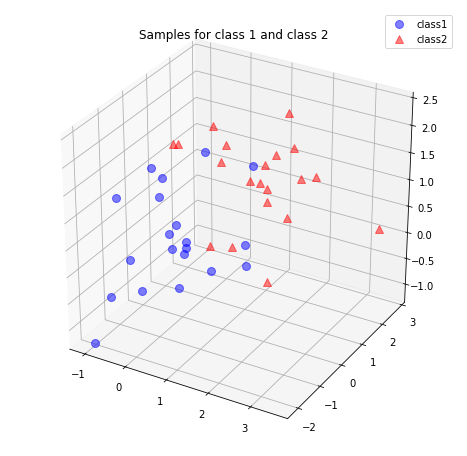

In [11]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
plt.rcParams['legend.fontsize'] = 10   
ax.plot(class1_sample[0,:], class1_sample[1,:], class1_sample[2,:], 'o', markersize=8, color='blue', alpha=0.5, label='class1')
ax.plot(class2_sample[0,:], class2_sample[1,:], class2_sample[2,:], '^', markersize=8, alpha=0.5, color='red', label='class2')

plt.title('Samples for class 1 and class 2')
ax.legend(loc='upper right')

plt.show()

## 2) compute the $d$-dimensional mean vector 

In [18]:
mean_x = np.mean(all_samples[0,:])
mean_y = np.mean(all_samples[1,:])
mean_z = np.mean(all_samples[2,:])

mean_vector = np.array([[mean_x],[mean_y],[mean_z]])

print('Mean Vector:\n', mean_vector)

Mean Vector:
 [[0.59451868]
 [0.47418087]
 [0.65295324]]


## 3) Option 1: Computing the Scatter Matrix
The scatter matrix is computed by the following equation:

$S = \sum_{k=1}^{n}(x_k - m) (x_k - m)^T$

where $m$ is the mean vector:

$m = \frac{1}{n}\sum_{k=1}^{n} x_k$

In [26]:
scatter_matrix = np.zeros((3,3))
for i in range(all_samples.shape[1]):
    scatter_matrix += (all_samples[:,i].reshape(3,1) - mean_vector).dot((all_samples[:,i].reshape(3,1) - mean_vector).T)
print('Scatter Matrix:\n', scatter_matrix)

Scatter Matrix:
 [[44.48216717 19.92027661 10.24622946]
 [19.92027661 80.81859836  6.31861714]
 [10.24622946  6.31861714 31.86687515]]


## 3) Option 2: Computing the Covariance Matrix 

Alternatively, instead of calculating the scatter matrix, we could also calculate the covariance matrix using the in-built `numpy.cov()` function. The equations for the covariance matrix and scatter matrix are very similar, the only difference is, that we use the scaling factor $\frac{1}{N-1}$ (here $\frac{1}{40-1}$) for the covariance matrix. Thus, their eigenspaces will be identical.

In [28]:
cov_mat = np.cov([all_samples[0,:],all_samples[1,:],all_samples[2,:]])
print('Covariance Matrix:\n', cov_mat)

Covariance Matrix:
 [[1.14056839 0.51077632 0.26272383]
 [0.51077632 2.07227175 0.16201582]
 [0.26272383 0.16201582 0.81709936]]


## 4) Computing eigenvectors and eigenvalues

In [31]:
# eigenvectors and eigenvalues from the scatter matrix
eig_val_sc , eig_vec_sc = np.linalg.eig(scatter_matrix)
# eigendvectors and eigenvalues from the covariance matrix
eig_val_cov, eig_vec_cov = np.linalg.eig(cov_mat)

for i in range(len(eig_val_sc)):
    eigvec_sc = eig_vec_sc[:,i].reshape(1,3).T
    eigvec_cov = eig_vec_cov[:,i].reshape(1,3).T
    print('Eigenvector {}: \n{}'.format(i+1, eigvec_sc))
    print('Eigenvalue {} from scatter matrix: {}'.format(i+1, eig_val_sc[i]))
    print('Eigenvalue {} from covariance matrix: {}'.format(i+1, eig_val_cov[i]))
    print('Scaling factor: ', eig_val_sc[i]/eig_val_cov[i])
    print(40 * '-')

Eigenvector 1: 
[[-0.41679817]
 [-0.89354934]
 [-0.16687978]]
Eigenvalue 1 from scatter matrix: 91.29052633245868
Eigenvalue 1 from covariance matrix: 2.3407827264732965
Scaling factor:  39.00000000000005
----------------------------------------
Eigenvector 2: 
[[-0.71415839]
 [ 0.43547209]
 [-0.54803454]]
Eigenvalue 2 from scatter matrix: 40.19819199824495
Eigenvalue 2 from covariance matrix: 1.0307228717498707
Scaling factor:  38.99999999999999
----------------------------------------
Eigenvector 3: 
[[-0.56236738]
 [ 0.1092412 ]
 [ 0.81963973]]
Eigenvalue 3 from scatter matrix: 25.678922354238427
Eigenvalue 3 from covariance matrix: 0.6584339065189342
Scaling factor:  38.99999999999999
----------------------------------------


### Checking the eigenvector-eigenvalue calculation

Let us quickly check that the eigenvector-eigenvalue calculation is correct and satisfies the equation

$\sum v = \lambda v$

where $\sum$ is the covariance matrix, $v$ is the eigenvector, and $\lambda$ is the eigenvalue

$\sum v$:

In [34]:
for i in range(len(eig_val_sc)):
    eigv = eig_vec_sc[:,i].reshape(1,3).T
    print(scatter_matrix.dot(eigv))

[[-38.0497245 ]
 [-81.57258953]
 [-15.23454302]]
[[-28.70787617]
 [ 17.50519056]
 [-22.02999749]]
[[-14.44098839]
 [  2.80519621]
 [ 21.04746498]]


$\lambda v$:

In [35]:
for i in range(len(eig_val_sc)):
    eigv = eig_vec_sc[:,i].reshape(1,3).T
    print(eig_val_sc[i] * eigv)

[[-38.0497245 ]
 [-81.57258953]
 [-15.23454302]]
[[-28.70787617]
 [ 17.50519056]
 [-22.02999749]]
[[-14.44098839]
 [  2.80519621]
 [ 21.04746498]]


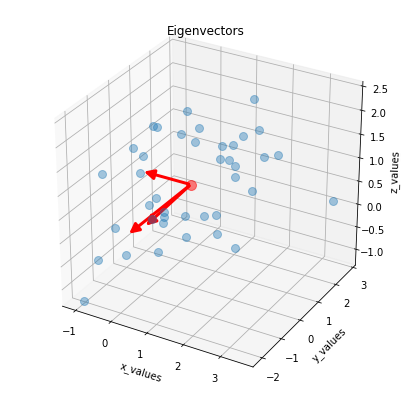

In [44]:
class Arrow3D(FancyArrowPatch):
    def __init__(self, xs, ys, zs, *args, **kwargs):
        FancyArrowPatch.__init__(self, (0,0), (0,0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
        self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))
        FancyArrowPatch.draw(self, renderer)

fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111, projection='3d')

ax.plot(all_samples[0,:], all_samples[1,:], all_samples[2,:], 'o', markersize=8,  alpha=0.4)
ax.plot([mean_x], [mean_y], [mean_z], 'o', markersize=10, color='red', alpha=0.5)
for v in eig_vec_sc.T:
    a = Arrow3D([mean_x, v[0]], [mean_y, v[1]], [mean_z, v[2]], mutation_scale=20, lw=3, arrowstyle="-|>", color="r")
    ax.add_artist(a)
ax.set_xlabel('x_values')
ax.set_ylabel('y_values')
ax.set_zlabel('z_values')

plt.title('Eigenvectors')

plt.show()

## 5) part 1: Sorting the eigenvectors by decreasing eigenvalues
In order to decide which eigenvector(s) we want to drop for our lower-dimensional subspace, we have to take a look at the corresponding eigenvalues of the eigenvectors. Roughly speaking, the eigenvectors with the lowest eigenvalues bear the least information about the distribution of the data, and those are the ones we want to drop.
The common approach is to rank the eigenvectors from highest to lowest corresponding eigenvalue and choose the top
k eigenvectors.

In [47]:
eig_val_sc

array([91.29052633, 40.198192  , 25.67892235])

In [52]:
eig_pairs = [(np.abs(eig_val_sc[i]), eig_vec_sc[:,i]) for i in range(len(eig_val_sc))]
eig_pairs

[(91.29052633245868, array([-0.41679817, -0.89354934, -0.16687978])),
 (40.19819199824495, array([-0.71415839,  0.43547209, -0.54803454])),
 (25.678922354238427, array([-0.56236738,  0.1092412 ,  0.81963973]))]

## 5) part 2: Choosing k eigenvectors with the largest eigenvalues

In [53]:
matrix_w = np.hstack((eig_pairs[0][1].reshape(3,1), eig_pairs[1][1].reshape(3,1)))
print('Matrix W:\n', matrix_w)

Matrix W:
 [[-0.41679817 -0.71415839]
 [-0.89354934  0.43547209]
 [-0.16687978 -0.54803454]]


## 6) Transforming the samples onto the new subspace

In the last step, we use the $2×3$-dimensional matrix $W$ that we just computed to transform our samples onto the new subspace via the equation $y=W^T×x$.

In [55]:
transformed = matrix_w.T.dot(all_samples)
assert transformed.shape == (2,40), "The matrix is not 2x40 dimensional."

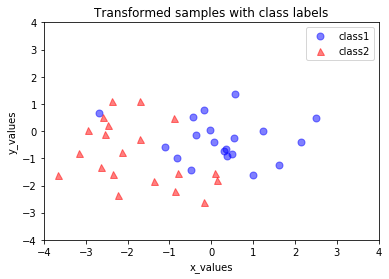

In [56]:
plt.plot(transformed[0,0:20], transformed[1,0:20], 'o', markersize=7, color='blue', alpha=0.5, label='class1')
plt.plot(transformed[0,20:40], transformed[1,20:40], '^', markersize=7, color='red', alpha=0.5, label='class2')
plt.xlim([-4,4])
plt.ylim([-4,4])
plt.xlabel('x_values')
plt.ylabel('y_values')
plt.legend()
plt.title('Transformed samples with class labels')

plt.show()


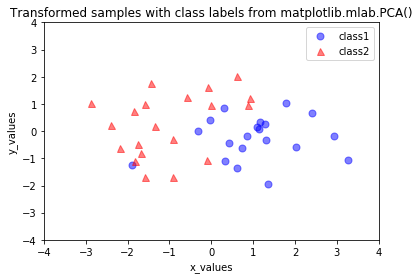

In [67]:
sklearn_pca = sklearnPCA(n_components=2)
sklearn_transf = sklearn_pca.fit_transform(all_samples.T)

plt.plot(sklearn_transf[0:20,0], sklearn_transf[0:20,1], 'o', markersize=7, color='blue', alpha=0.5, label='class1')
plt.plot(sklearn_transf[20:40,0], sklearn_transf[20:40,1], '^', markersize=7, color='red', alpha=0.5, label='class2')

plt.xlabel('x_values')
plt.ylabel('y_values')
plt.xlim([-4,4])
plt.ylim([-4,4])
plt.legend()
plt.title('Transformed samples with class labels from matplotlib.mlab.PCA()')

plt.show()

If you see closely it seems that the y axis of both the plots have a negative relationship. They are exactly the same when you flip one the plot's y

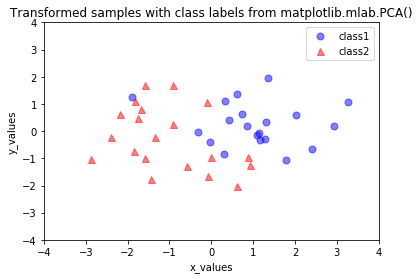

In [68]:
plt.plot(sklearn_transf[0:20,0], -sklearn_transf[0:20,1], 'o', markersize=7, color='blue', alpha=0.5, label='class1')
plt.plot(sklearn_transf[20:40,0], -sklearn_transf[20:40,1], '^', markersize=7, color='red', alpha=0.5, label='class2')

plt.xlabel('x_values')
plt.ylabel('y_values')
plt.xlim([-4,4])
plt.ylim([-4,4])
plt.legend()
plt.title('Transformed samples with class labels from matplotlib.mlab.PCA()')

plt.show()